In [1]:
import tensorflow as tf # for model
import pandas as pd # for reading and processing data
import seaborn as sns # visualization => Không cần plot
from tensorflow.keras.layers import Dense, Normalization, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import classification_report

2024-08-20 20:06:46.049482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 20:06:47.547204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Task Understanding

- Nguồn dataset: https://www.kaggle.com/datasets/mayankpatel14/second-hand-used-cars-data-set-linear-regression
- Thực hiện từ: 4:14:52 đến 6:28:50
- Sử dụng linear regression model và mạng neutron để dự đoán giá xe cũ dựa theo các thông số như số năm sử đã sử dụng, số km đã đi, ...
- Vòng đời của 1 quá trình train mạng neutron
   - Task Understand: Xác định nhiệm vụ cần làm
   - Data Preparation: Tiền xử lý và hiểu dữ liệu. Nó gồm các bước load dataset visualization để hiểu nó và đưa ra quyết định tiền xử lý thậm chí là cách tạo ra mạng neutron
   - Error Measurement: Xác định lose function phù hợp với kiến trúc mạng neutron định xây
   - Training và Optimization: xây dựng mạng neutron và train model và tối ưu hóa hiệu suất. Validation trong quá trình train để xác định Overfitting và Underfitting.
   - Testing: Xác định hiệu xuất cuối cùng của model
   - Corrective Measures: Biện pháp khác phục

# Data Preparation

## Load data

In [2]:
data = pd.read_csv('train.csv', sep=',')
data.head()

v.id  on road old  on road now  years      km  rating  condition  economy  \
0     1       535651       798186      3   78945       1          2       14   
1     2       591911       861056      6  117220       5          9        9   
2     3       686990       770762      2  132538       2          8       15   
3     4       573999       722381      4  101065       4          3       11   
4     5       691388       811335      6   61559       3          9       12   

   top speed  hp  torque  current price  
0        177  73     123       351318.0  
1        148  74      95       285001.5  
2        181  53      97       215386.0  
3        197  54     116       244295.5  
4        160  53     105       531114.5

In [3]:
data.shape

(1000, 12)

## Visualizae data để thấy được sự phân tán dữ liệu và đưa ra thuật toán machine learning thích hợp

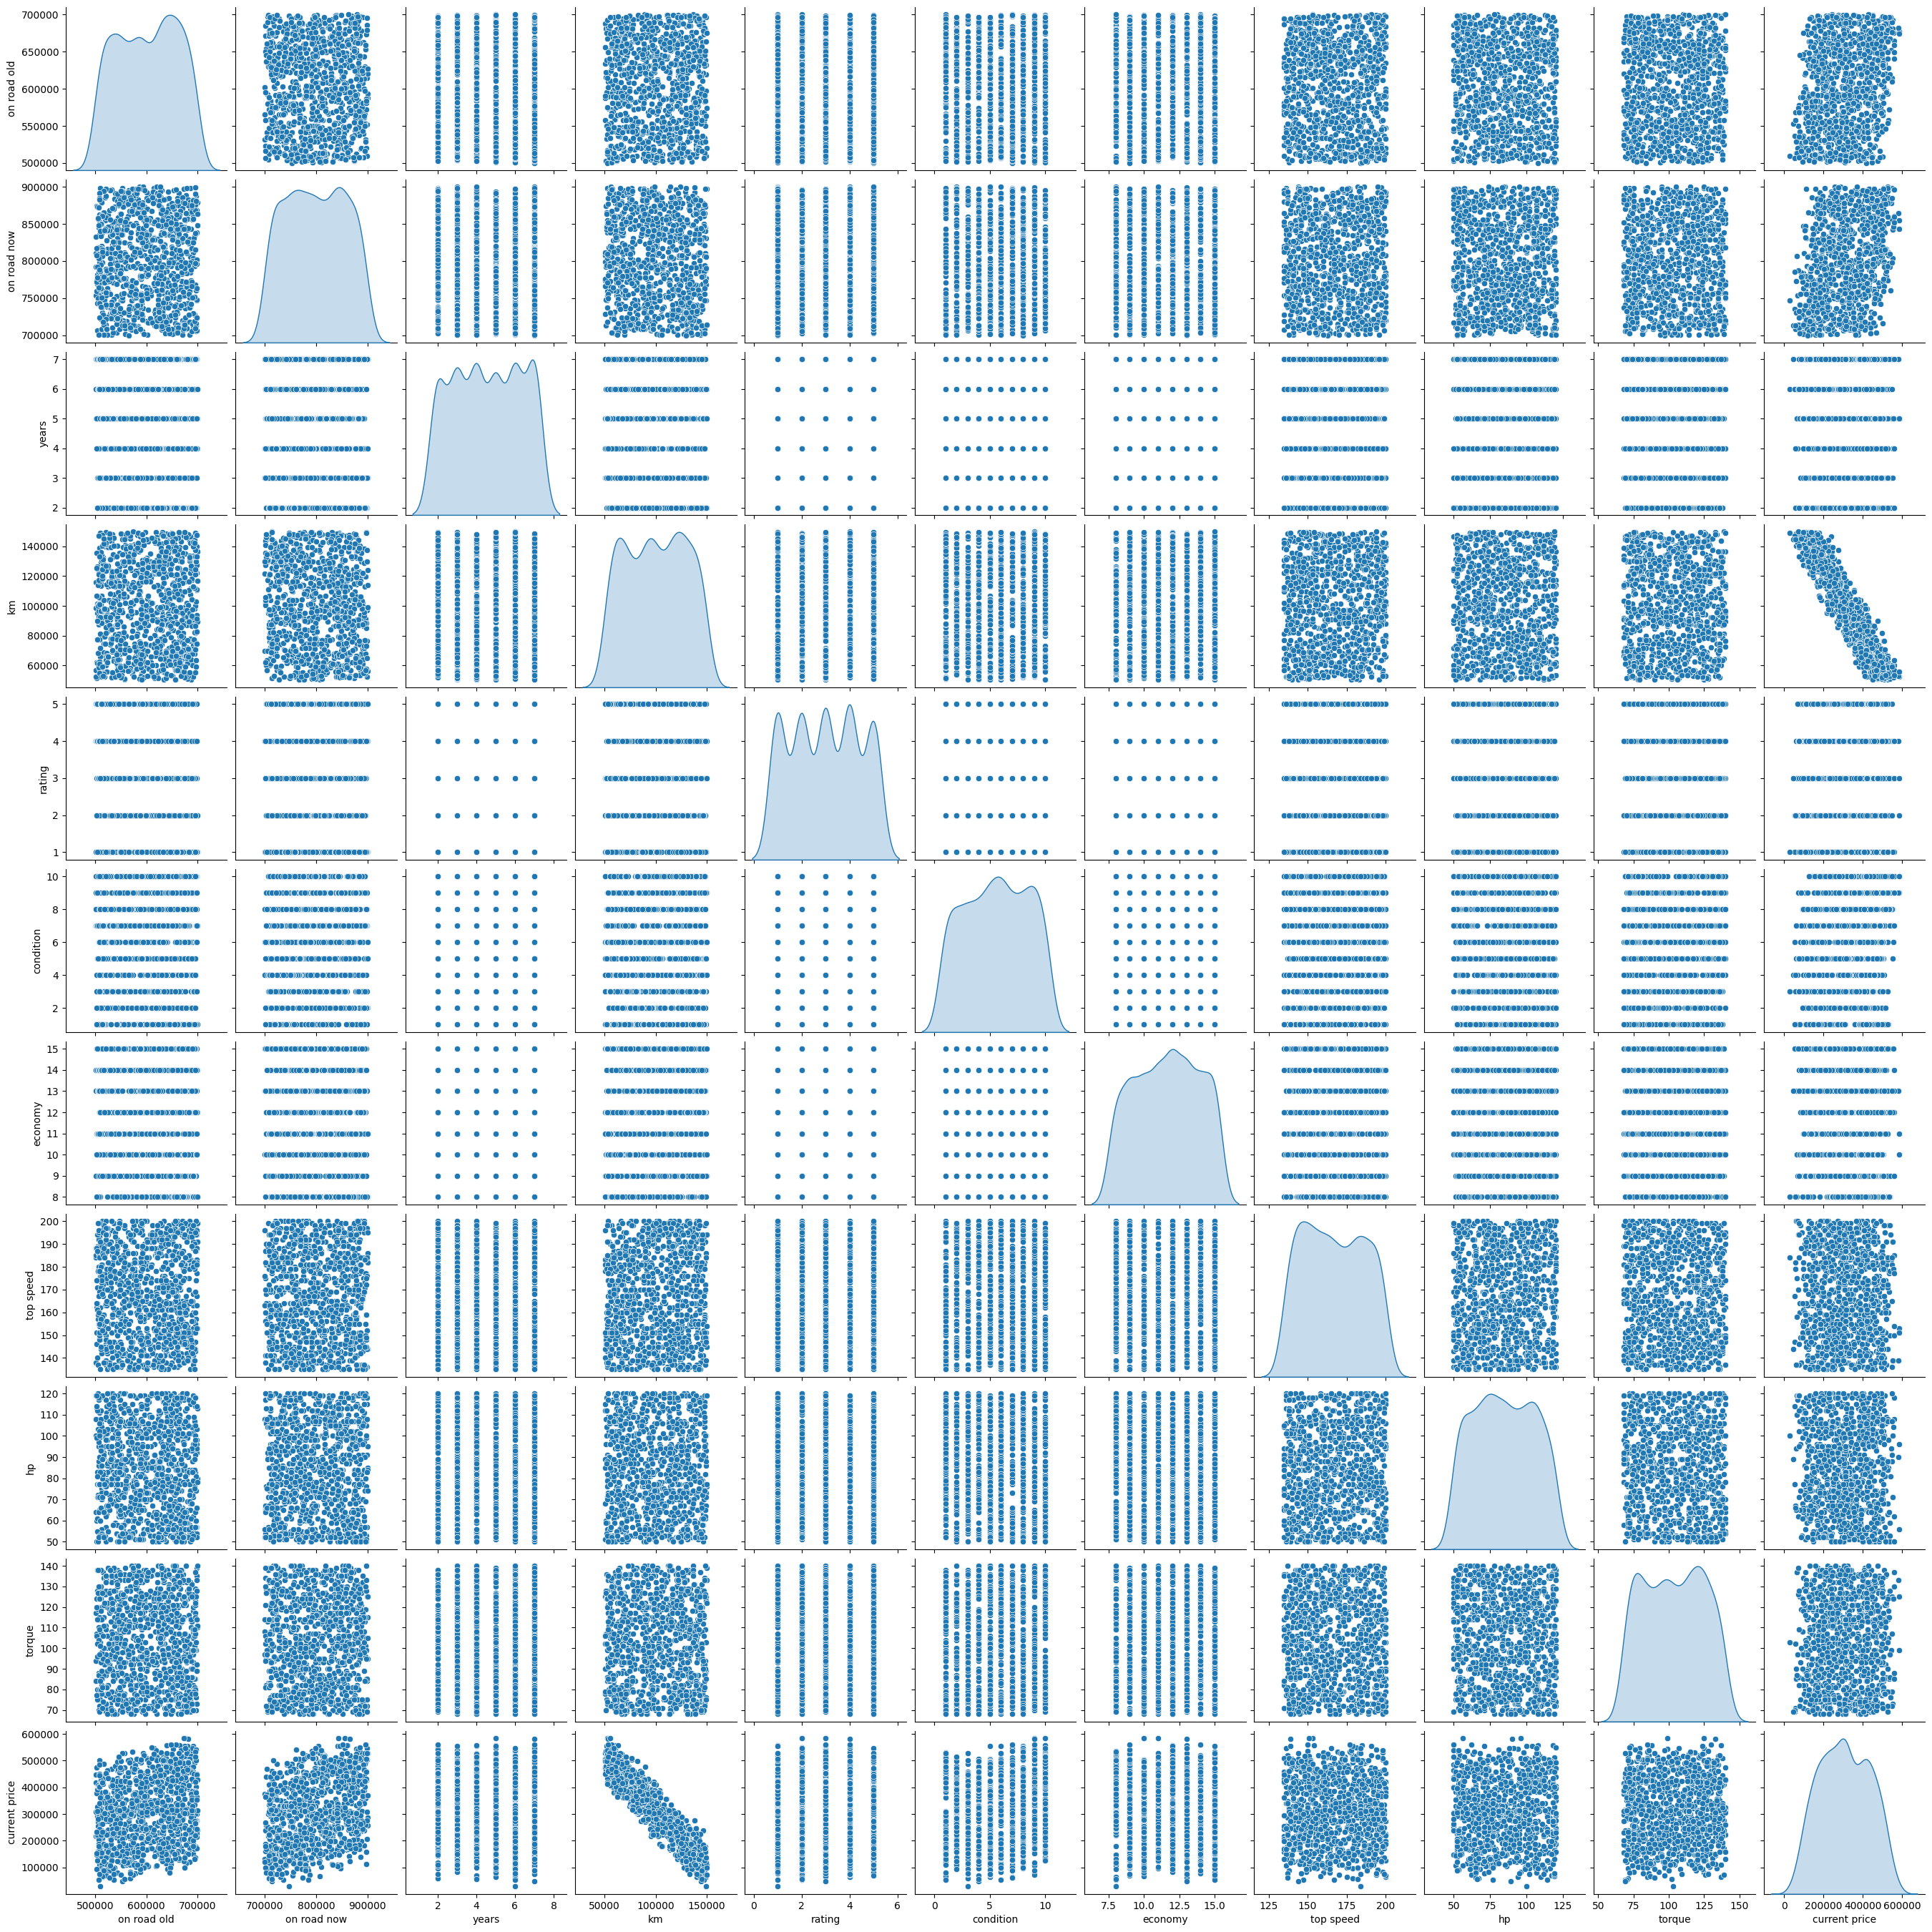

In [4]:
# kde là candal density estimate (ước tính mật độ nến)
sns.pairplot(data[['on road old', 'on road now', 'years', 'km', 'rating', 'condition', 'economy', 'top speed', 'hp', 'torque', 'current price']], diag_kind='kde')

Sau khi có hình ảnh mức độ phân tán của dữ liệu như trên, nên nhớ là ta cần sử dụng linear regression model để dự đoán current price nên ta sẽ chú ý dòng cuối cùng

## Các kỹ thuật tiền xử lý

In [5]:
# 1: shuffer data lên để tránh lỗi gây ra bởi thứ tự thu thập dữ liệu
    # làm việc với tensorflow thì nên convert pandas sang tensor
tensor_data = tf.constant(data)
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data[:5])

tf.Tensor(
[[1.430000e+02 5.655760e+05 8.947460e+05 7.000000e+00 1.129100e+05
  4.000000e+00 5.000000e+00 1.000000e+01 1.710000e+02 1.070000e+02
  1.130000e+02 2.724375e+05]
 [4.330000e+02 5.649800e+05 7.275380e+05 3.000000e+00 1.116220e+05
  1.000000e+00 8.000000e+00 1.500000e+01 1.350000e+02 9.100000e+01
  1.350000e+02 2.163270e+05]
 [8.650000e+02 6.166140e+05 8.284220e+05 6.000000e+00 1.446440e+05
  4.000000e+00 1.000000e+00 1.100000e+01 1.650000e+02 7.900000e+01
  9.500000e+01 1.407965e+05]
 [5.790000e+02 6.872460e+05 7.877540e+05 2.000000e+00 1.267600e+05
  5.000000e+00 4.000000e+00 9.000000e+00 1.650000e+02 5.600000e+01
  9.800000e+01 2.327185e+05]
 [8.200000e+01 5.481290e+05 8.630550e+05 2.000000e+00 7.725000e+04
  2.000000e+00 8.000000e+00 1.500000e+01 1.840000e+02 1.140000e+02
  1.010000e+02 4.132880e+05]], shape=(5, 12), dtype=float64)


2024-08-20 20:07:10.967703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-20 20:07:11.164035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-20 20:07:11.164300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
# 2: Tách tensor ra làm 2 ma trận X, y phục vụ train và bỏ 3 cột đầu trong dataset đi trong feature matrix X. Làm đầu vào của dataset APi trong tensorflow luôn
    # Dâu ":" đầu tiên là chỉ số lượng hàng do không chỉ nên sẽ lấy tất cả các row hay tất cả các quan sát x
    # "3:-1" là chỉ số cột, nó sẽ lấy số column 3 đến column trước column -1
X = tensor_data[:,3:-1]
print(X.shape)

y = tensor_data[:,-1]
print(y[:5].shape)
    # Thêm chiều cho ma trận y để phù hợp với input shape của các model
y = tf.expand_dims(y, axis = -1)
print(y[:5]) # có thể thấy từ ma trận 1 chiều có 5 phần tử đã chuyển thành ma trận có chiều (5, 1)

(1000, 8)
(5,)
tf.Tensor(
[[272437.5]
 [216327. ]
 [140796.5]
 [232718.5]
 [413288. ]], shape=(5, 1), dtype=float64)


In [7]:
# 3: Chia dataset thành các tập train/val/test set
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(tensor_data)

In [8]:
X_train, X_val, X_test = tf.split(X, [int(DATASET_SIZE*TRAIN_RATIO), int(DATASET_SIZE*VAL_RATIO), int(DATASET_SIZE*TEST_RATIO)])
y_train, y_val, y_test = tf.split(y, [int(DATASET_SIZE*TRAIN_RATIO), int(DATASET_SIZE*VAL_RATIO), int(DATASET_SIZE*TEST_RATIO)])
print(X_train.shape, X_val.shape, X_test.shape)

(800, 8) (100, 8) (100, 8)


In [9]:
# 4: Sử dụng api dataset trong tensorflow để tốc độ xử lý hay việc triển khai model train nhanh nhất
    # Đọc doc https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    # buffer_size: lấy 8 phần tử đầu tiên của tập và chọn ngẫu nhiên 1 trong số đó, sau đó phần tử tiếp theo trong tập sẽ được ném vào buffer và tiếp tục chọn random 1 phần tử từ buffer
    # reshffle_each_iteration: sau mỗi epoch (mỗi lần dataset được duyệt qua 1 lần), dataset sẽ được xáo trộn lại theo cơ chế buffer_size ở trên. Điều này tăng tính ngẫu nhiên và giảm thiểu overfitting do thứ tự dữ liệu train gây ra đặc biệt là khi dataset nhỏ
    # batch: thay vì đưa cả dataset để vẽ ra đồ thị và tính đạo hàm tìm ra delta cần điều chỉnh, ta chỉ lấy 32 sample để vẽ đồ thị. Điều này giúp tôi ưu hóa hiệu suất tính toán
    # prefetch: Hầu hết training set pipeline thường kết thúc bằng cách gọi prefetch. Điều này cho phép lấy trước các samples để tạo thành batch mới trong khi batch cũ đang được train. Bằng cách này, khi batch cũ được train xong sẽ có ngay batch mới và không cần phải đợi tạo batch mới. tf.data.AUTOTUNE là 1 tùy chọn giúp tensorflow tự động xác định số lượng batch nên được prefetch (lấy trước)
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

# Training model

## Xây dựng kiến trúc model (mạng neutron hoặc thuật toán machine learning nào đó)

Các bước xây dựng model
- Xác định kiến trúc model (dạng model là fully connected model, số neutron trong mỗi layer, activation function)
- Xác định thuật toán train
- Xác dịnh loss function
- Xác định callback

Chuẩn hóa dữ liệu: Mục đích làm cho giá trị của các trường nhỏ hơn dẫn đến delta w nhỏ hơn sau mỗi lần train

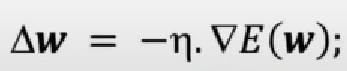

=> Tại mỗi bước train model, giá trị của các parameter cần train sẽ nhỏ hơn và thay đổi ít hơn => Train nhanh hội tụ hơn

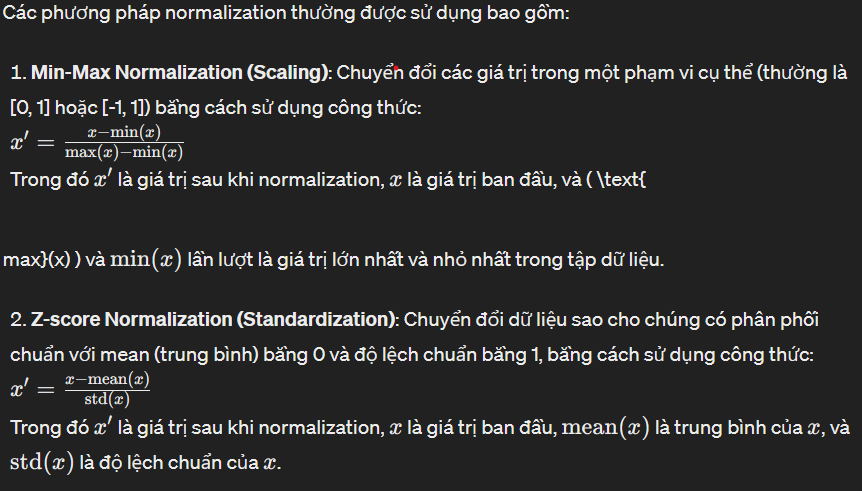

In [11]:
# 1: Khai báo biến Normalize data. Biến này sẽ được sử dụng để làm 1 layer trong input shape của mạng neutron
# Tham khảo tại: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
normalizer = Normalization()

# Ví dụ normalization ma trận X theo phân phối chuẩn
normalizer.adapt(X) # Cái này nghĩa là tự xác định mean và variance (phương sai) dựa theo ma trân X
normalizer(X)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[ 1.4194925 ,  0.43367726,  0.72177976, -0.20970327, -0.72888464,
         0.2130324 ,  1.0949605 ,  0.4550038 ],
       [-0.9084984 ,  0.3894706 , -1.4178834 ,  0.85298216,  1.5138373 ,
        -1.6543103 ,  0.31472683,  1.5002246 ],
       [ 0.8374948 ,  1.5228496 ,  0.72177976, -1.6266172 , -0.28034025,
        -0.09819138, -0.27044836, -0.40017688],
       [-1.4904962 ,  0.9090361 ,  1.4350008 , -0.56393176, -1.177429  ,
        -0.09819138, -1.3920342 , -0.25764677],
       [-1.4904962 , -0.790243  , -0.7046623 ,  0.85298216,  1.5138373 ,
         0.8873506 ,  1.4363126 , -0.11511666]], dtype=float32)>

Có 3 cách để định nghĩa kiến trúc của 1 model trong tensorflow
- Sequential API: Chỉ có thể dùng để xây dựng Sequential model (tuần tự), còn nếu model kiểu đệ quy như Resnet thì không được phải sử dụng Fuctional API hoặc Subclassing . https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- Functional API: Xây dựng model bằng tay
- Subclassing method: Xây dựng model bằng tay nhưng theo hướng class và có thể tái sử dụng

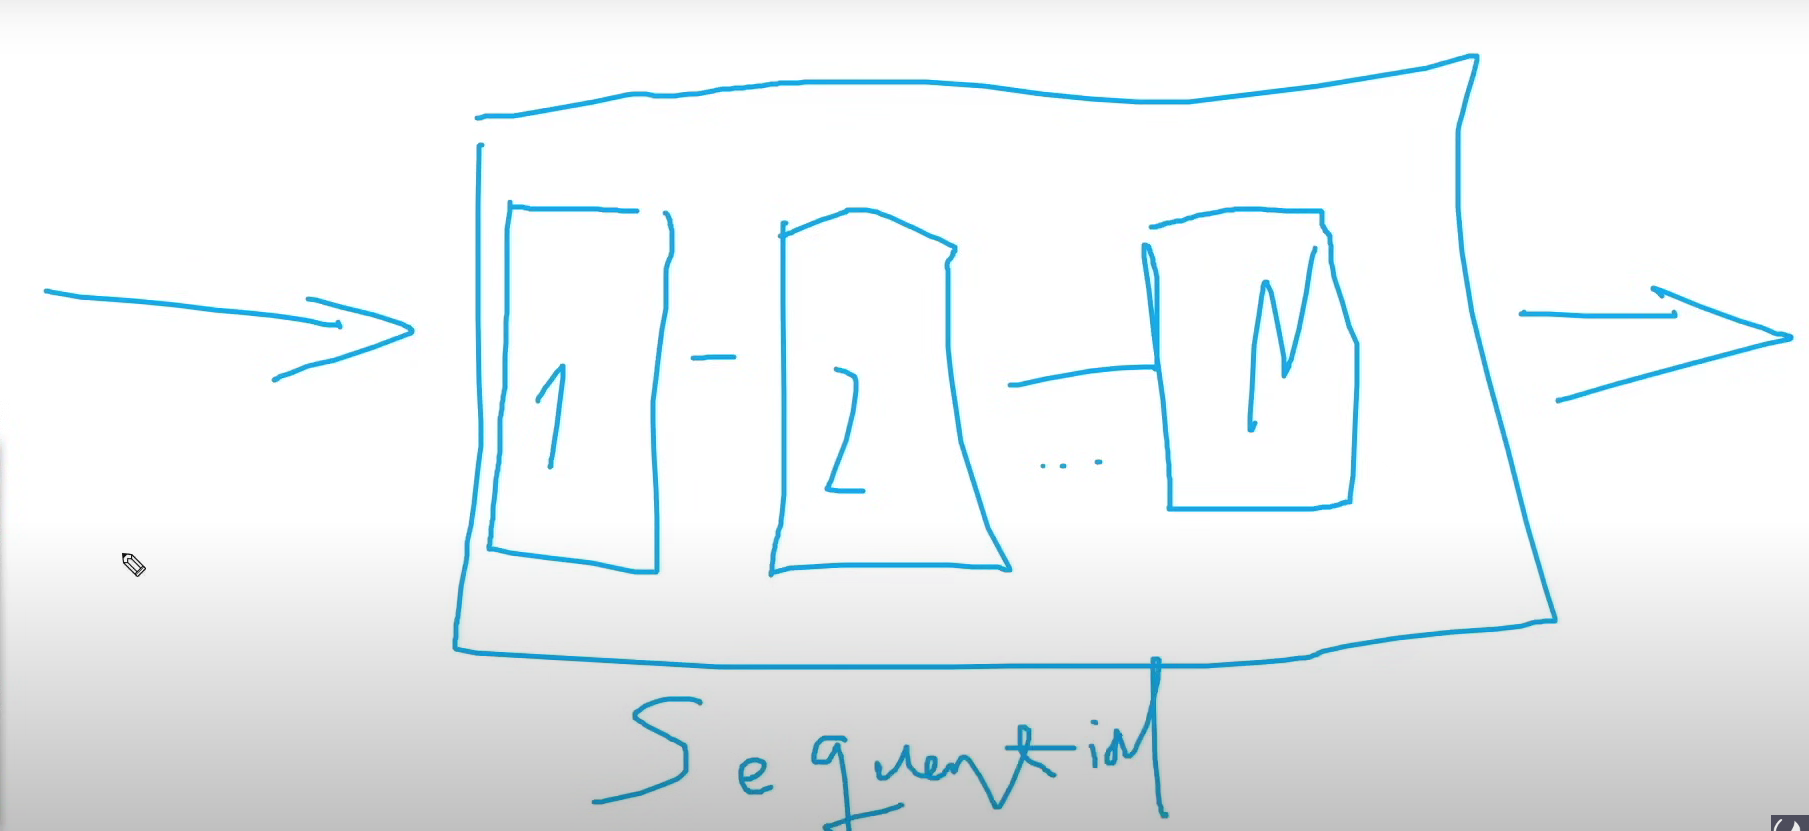

In [12]:
model =  tf.keras.Sequential([
    InputLayer(input_shape = (8 ,)), # Dùng để xác định shape của input khi đi vào model, kết hợp với batch(32) của dataset API mà ta config cho training set là đẹp
    normalizer, # Khi sử dụng normalizer thế này nó sẽ tự động adap() như ở ví dụ trên với training set
    # Dense layer là hidden layer thuộc dạng fully connected layer, chứa số neutron và actiavation function của mỗi neutron trong nó
    Dense(128, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(1)
])
model.summary()

/home/vohoang/miniconda3/envs/tfgpu_2.16.1/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,322 (134.07 KB)

 Trainable params: 34,305 (134.00 KB)

 Non-trainable params: 17 (72.00 B)

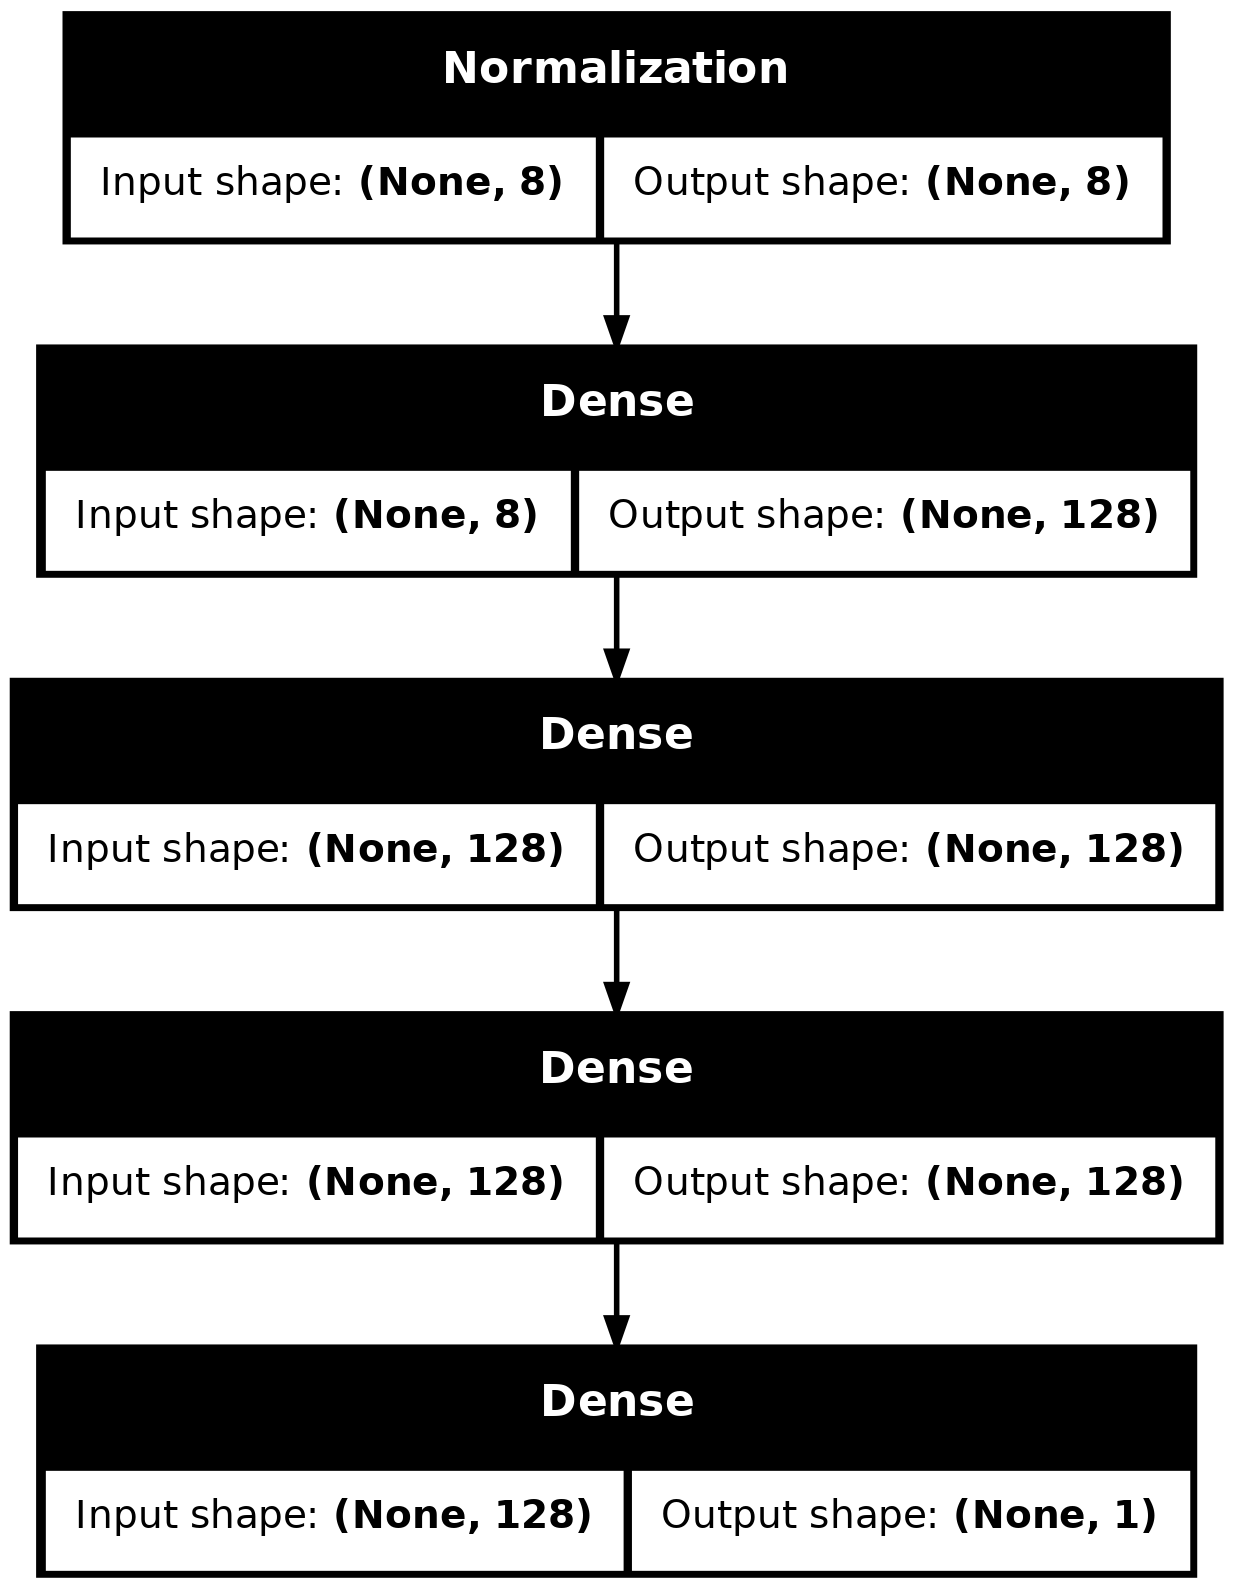

In [13]:
# Để nhìn rõ hơn kiến trúc ta có thể plot nó ra
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

Các Optimizer: Là thuật toán dùng để train mạng netron
- Thường chọn thuật toán Adam (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), SGD(https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), ...
- Theo mặc định hàm compile sử dụng là rmseprop, chi tiết xem tại https://www.tensorflow.org/api_docs/python/tf/keras/Model

Các loại loss function
- MAE (mean absolute error): Nếu không muốn model bị ảnh hưởng quá nhiều bởi ngoại lệ (1 data point nằm cách xa đường thẳng dự đoán) thì dùng

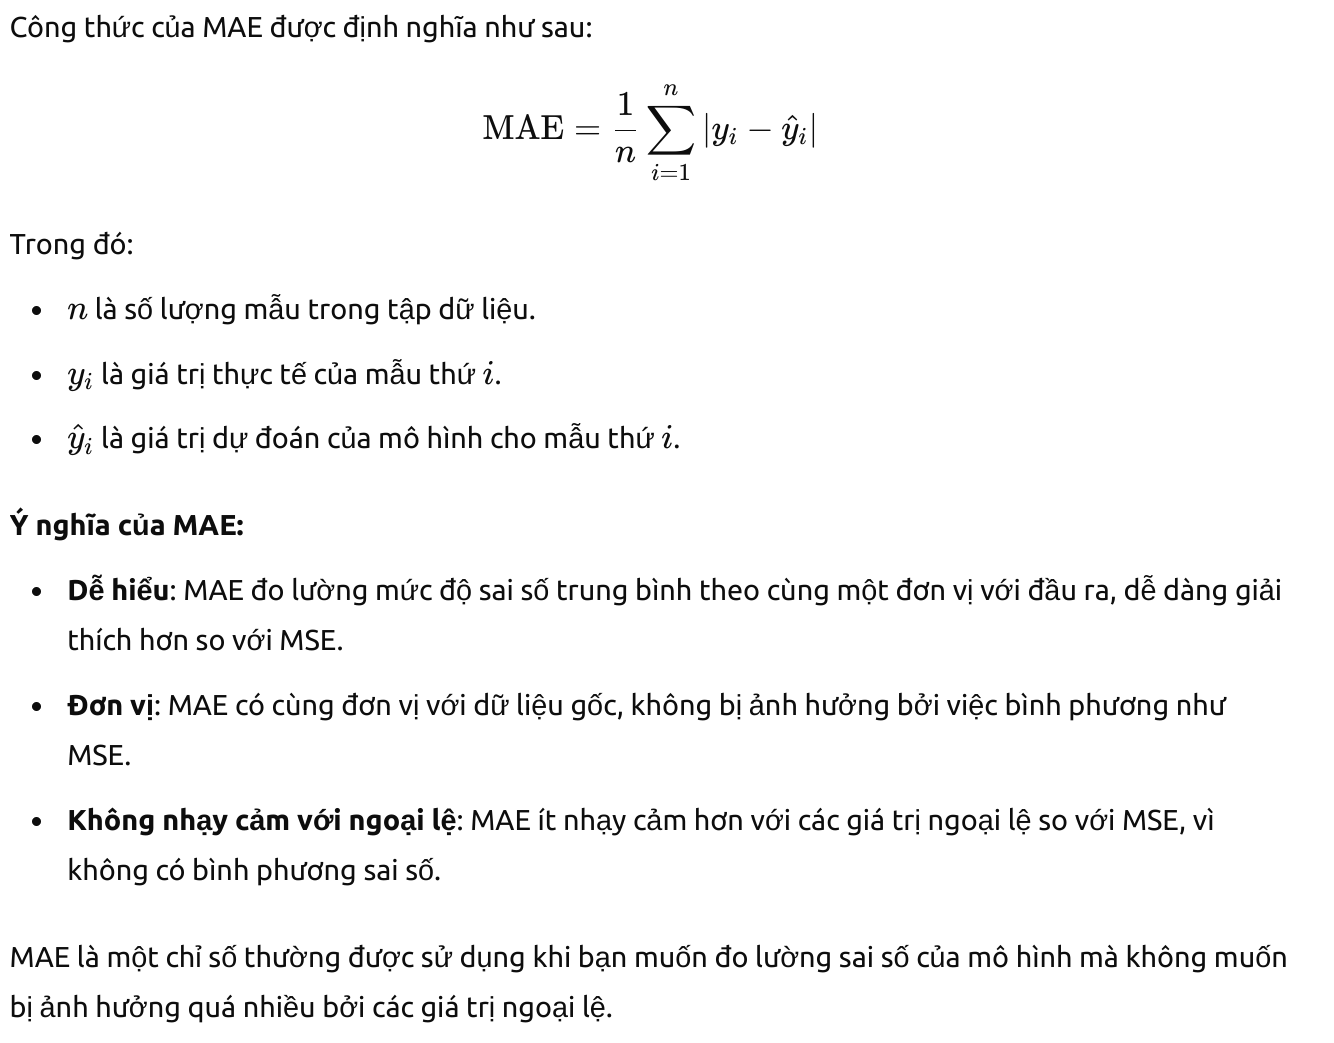

- MSE (mean squared error): Nếu muốn model nhạy cảm hơn với các ngoại lệ thì dùng vì bình phương thì giá trị loss đo được sẽ lớn hơn

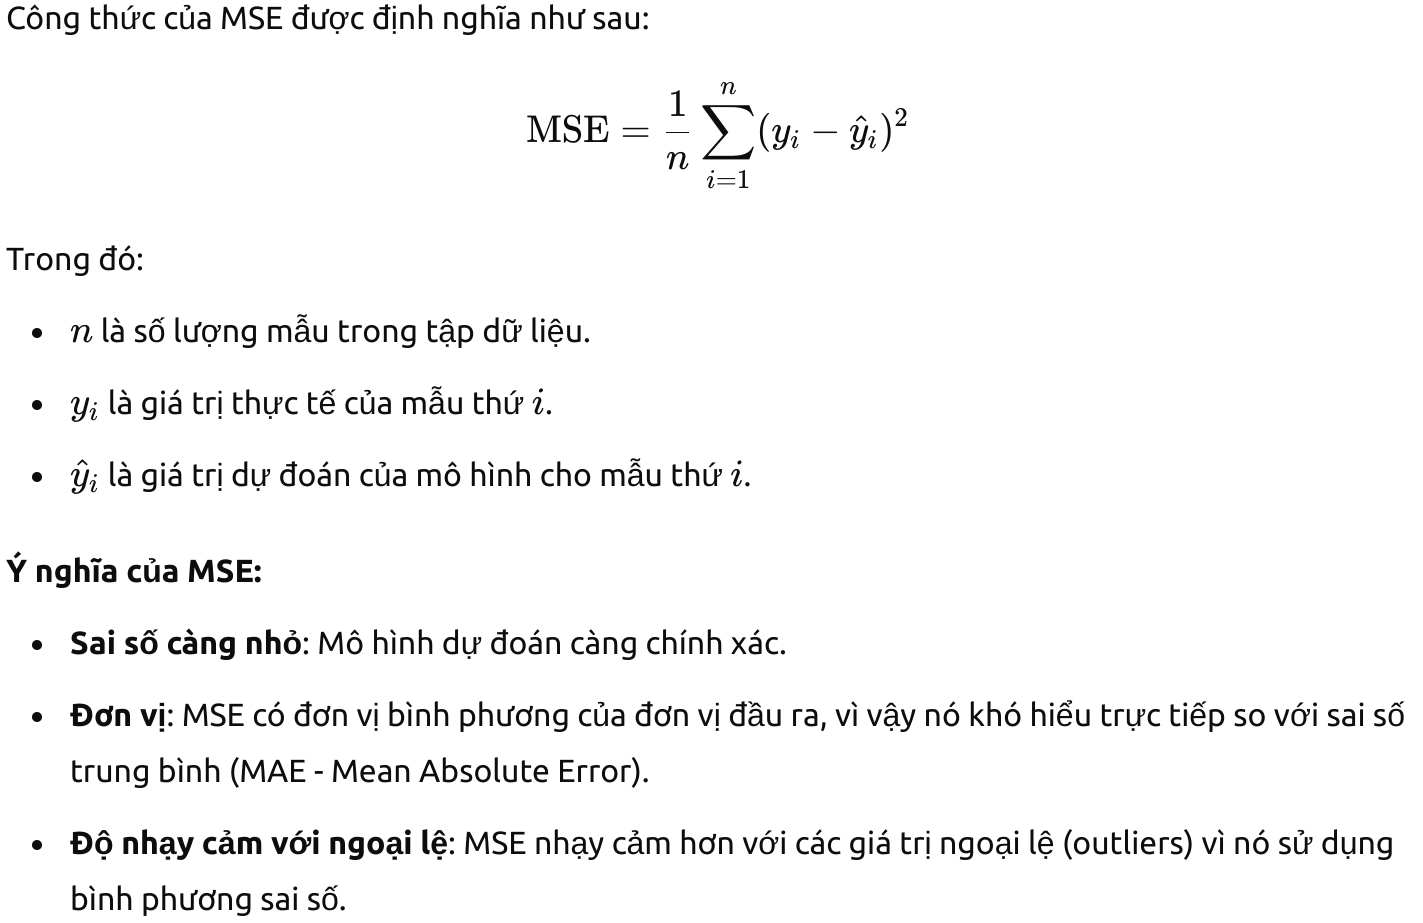

Tóm lại khi train model mà cho ra kết quả không tốt thì quay lại đây chỉnh lại loss function sao cho model train ra có performance tốt nhất

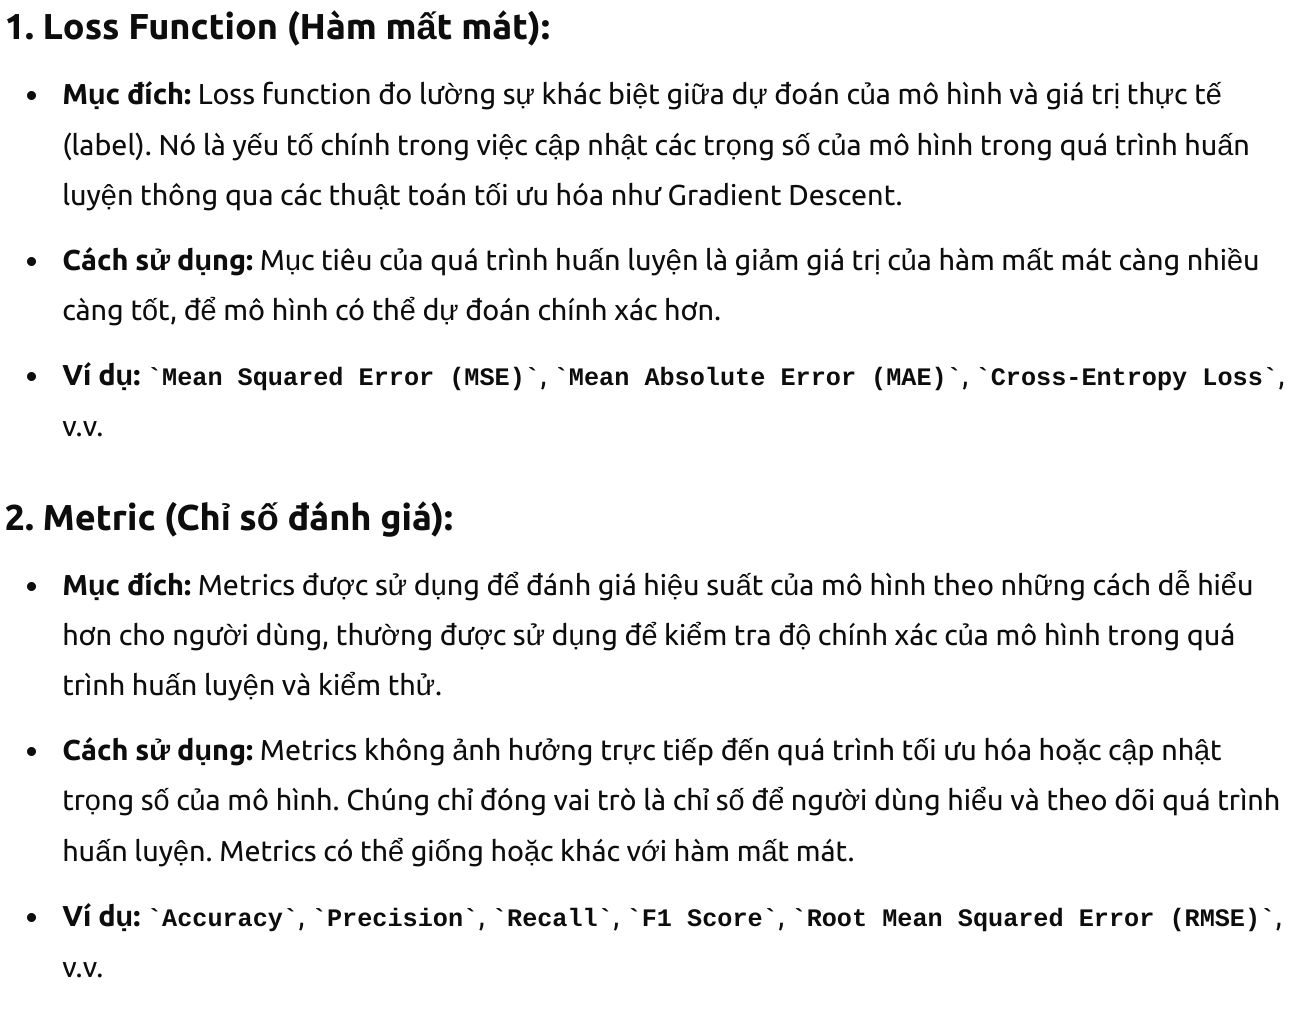

In [14]:
# Định nghĩa loss function cho model
model.compile(
    optimizer = Adam(),
    loss = MeanAbsoluteError(),
    metrics = [RootMeanSquaredError()]
)

## Training

In [15]:
history = model.fit(train_dataset, validation_data=val_dataset ,epochs=100, verbose=1)

Epoch 1/100


I0000 00:00:1724160721.575252    3907 service.cc:145] XLA service 0x7ba480005b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724160721.575330    3907 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-08-20 20:32:01.640113: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-20 20:32:01.914117: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 326459.3438 - root_mean_squared_error: 349945.8125

I0000 00:00:1724160722.555466    3907 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 311968.9062 - root_mean_squared_error: 335844.0000 - val_loss: 309968.1562 - val_root_mean_squared_error: 336928.9062
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 311794.9375 - root_mean_squared_error: 335679.4062 - val_loss: 309896.1250 - val_root_mean_squared_error: 336862.8125
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 311893.7500 - root_mean_squared_error: 335699.9062 - val_loss: 309574.1562 - val_root_mean_squared_error: 336566.5938
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 311953.0938 - root_mean_squared_error: 335887.6875 - val_loss: 308583.6875 - val_root_mean_squared_error: 335653.1250
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 310113.6875 - root_mean_squared_error: 334180.7812 - val_loss: 306183.5312 - val_root_mean_squared_error: 333437.3125
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 307618.6250 - root_mean_squared_error: 331808.0312 - val_loss: 3012

Visualization các metric để đánh giá loss và các metric, dựa vào kết quả này để kết luận có nên chỉnh sửa lại mạng neutron, thuật toán, ... không để đạt được model như ý muoons

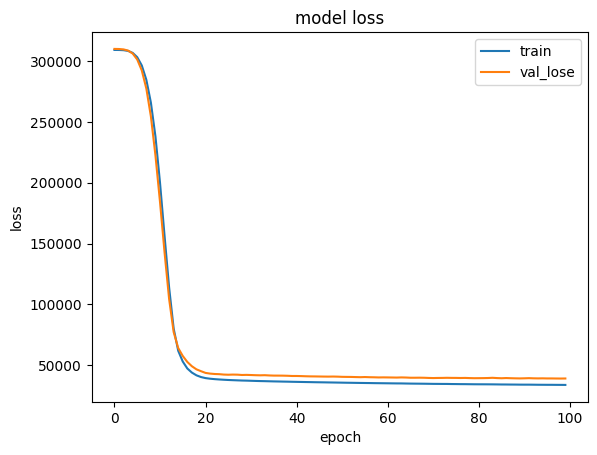

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_lose'])
plt.show()

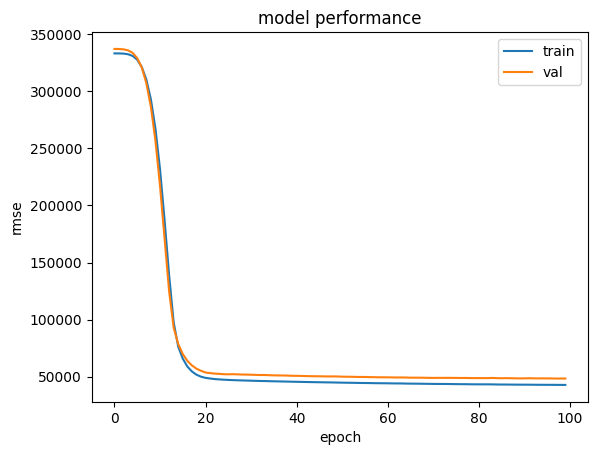

In [17]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

## Corrective Measures (biện pháp khắc phục)

Under fitting xảy ra khi mô hình không thể học đủ thông tin từ dữ liệu huấn luyện và do đó không thể tổng quát hóa tốt cho dữ liệu mới hoặc dữ liệu thực tế.

Các dấu hiệu chính của under fitting bao gồm:
- Hiệu suất thấp trên dữ liệu huấn luyện
- Hiệu suất thấp trên dữ liệu kiểm tra hoặc dữ liệu mới
- Dự đoán không chính xác

Để khắc phục cần:
- Tăng cường dữ liệu - Data augmentaition: Tăng cường dữ liệu có thể giúp mô hình học được nhiều biến thể và mẫu dữ liệu hơn từ tập dữ liệu huấn luyện.
- Tinh chỉnh siêu tham số - Hyperparameter tuning: Điều chỉnh các siêu tham số của mô hình như số lượng lớp, số lượng neuron, hệ số học (learning rate), v.v. để cải thiện hiệu suất của mô hình.

Over fitting: Mô hình học máy được huấn luyện quá tốt đối với training data nhưng không tổng quát hóa được trên lượng dữ liệu mới. Có nghĩa mô hình này đã học được các chi tiết và biến thể của training data đến mức nó bắt đầu học cả nhiễu và những thông tin không cần thiết (học quá nhiều)

Các vấn đề phổ biến báo hiệu mô hình over fitting
- Hiệu suất tốt trên tập training set
- Hiệu suất kém trên test set, validation set
- Đồ thị học (learning curve): không ổn định. Đồ thị độ lỗi trên cả tập huấn luyện và tập kiểm tra có xu hướng tăng lên sau một thời gian, trong khi độ lỗi trên tập huấn luyện giảm xuống.

Cách khắc phục
- Tăng cường dữ liệu (Data augmentation): Tăng cường dữ liệu có thể giúp mô hình học được các biến thể và mẫu dữ liệu mới từ tập huấn luyện, giảm thiểu khả năng overfitting
- Sử dụng mô hình đơn giản hơn: Thay vì sử dụng mô hình quá phức tạp, bạn có thể sử dụng một mô hình đơn giản hơn để tránh việc học cả nhiễu và thông tin không cần thiết trong dữ liệu.
- Sử dụng kỹ thuật dropout: Dropout là một kỹ thuật regularization phổ biến trong deep learning, nó ngẫu nhiên loại bỏ một số neuron trong quá trình huấn luyện, từ đó giảm thiểu khả năng mô hình học những chi tiết không cần thiết.
- Early stopping: Dừng quá trình huấn luyện khi độ lỗi trên tập kiểm tra bắt đầu tăng lên, thay vì tiếp tục huấn luyện cho đến khi độ lỗi trên tập huấn luyện giảm xuống gần như không đáng kể.
- Regularization: Sử dụng các kỹ thuật regularization như L1 regularization, L2 regularization để giảm thiểu sự phức tạp của mô hình và ngăn chặn việc học quá mức.

# Test model

Mục đích của bước này là đưa ra kết quả cuối cùng của quá trình train model. Model sau khi train sẽ được predict trên 1 dataset mà nó chưa từng nhìn thấy. Đó là test set

In [18]:
model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 38989.1016 - root_mean_squared_error: 47387.9531


[38640.70703125, 47547.66015625]

In [19]:
y_pred = model.predict(X_test)
y_pred.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


(100, 1)

In [20]:
# Chuyển tensor thành numpy array để vẽ đồ thị
y_pred_np = list(y_pred[:,0])
y_test_np = list(y_test[:,0].numpy())

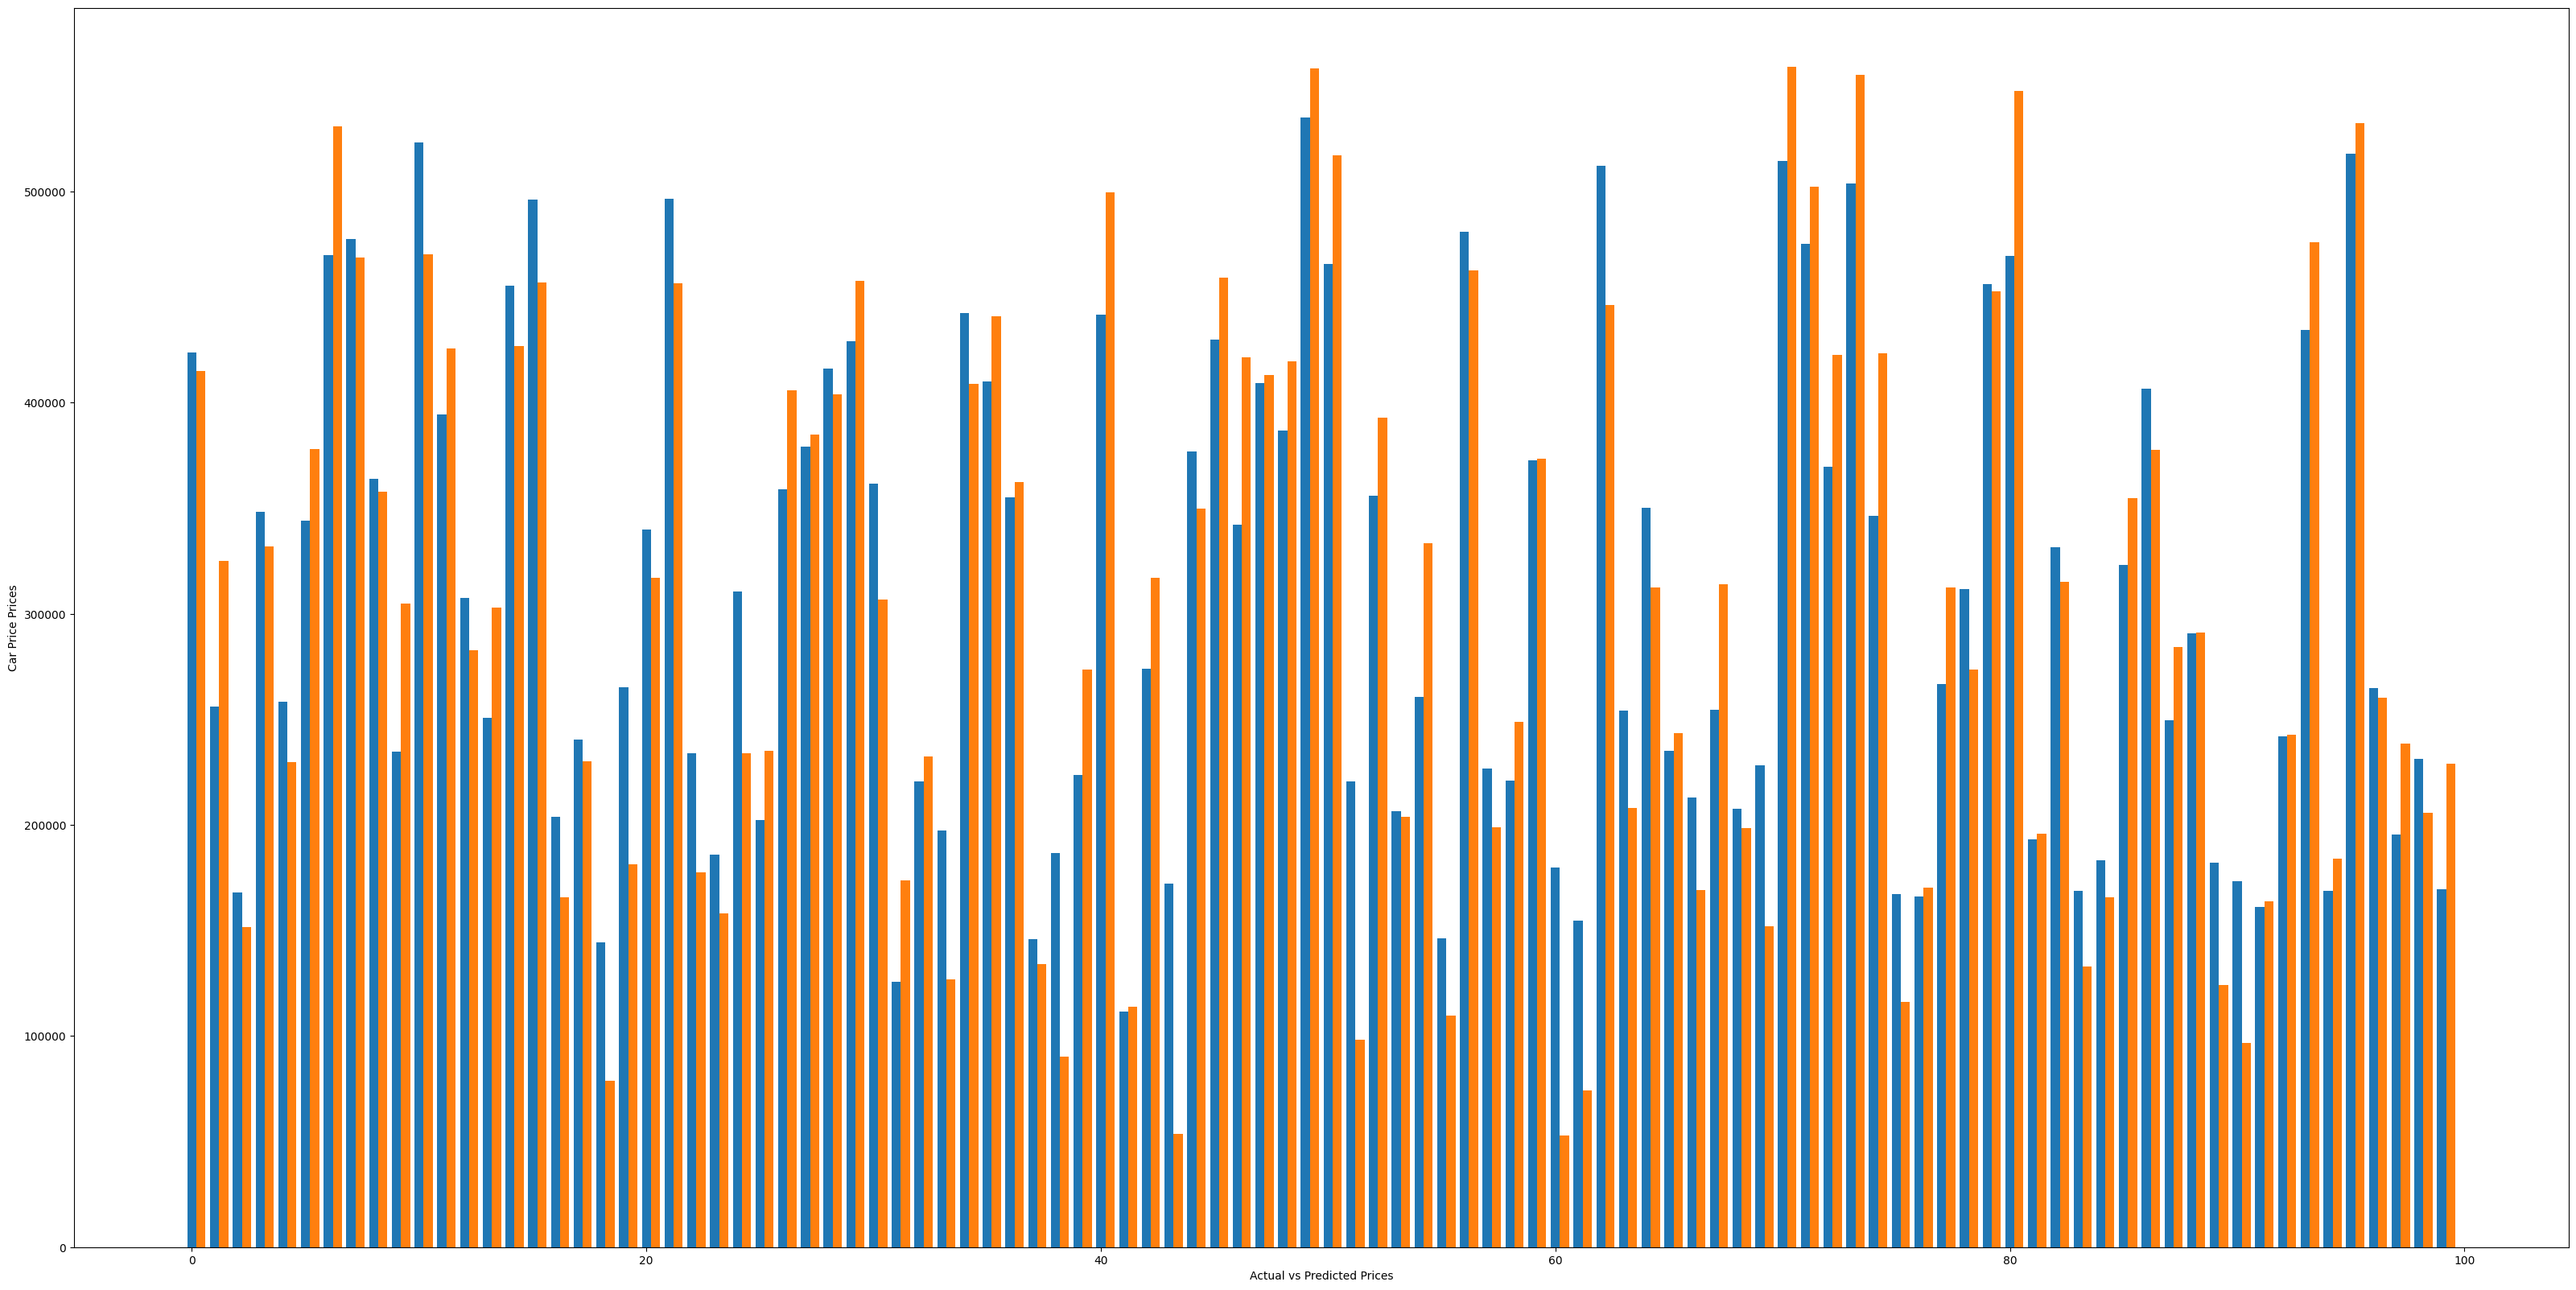

In [21]:
import numpy as np

ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.4
plt.bar(ind, y_pred_np, width, label= "Predicted Car Price")
plt.bar(ind + width, y_test_np, width, label= "Actual Car Price")

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')

plt.show()